In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor


pd.set_option('future.no_silent_downcasting', True)

In [2]:
# Загружаем данные
data_df = pd.read_csv('/kaggle/input/nxtr-tst/task.csv')

# Преобразуем пустое значение страны в "Not defined"
data_df['cc'] = data_df['cc'].fillna('Not defined')

In [3]:
# Насчитываем признаки транзакций
data_df['login_count'] = np.where(data_df['eventId']==1, 1, 0)
data_df['payment_revenue'] = np.where(data_df['eventId']==2, data_df['eventValue'], 0)
data_df['levelup'] = np.where(data_df['eventId']==3, data_df['eventValue'], 0)
data_df['tutorial_complete'] = np.where(data_df['eventId']==4, 1, 0)
data_df['ad_revenue'] = np.where(data_df['eventId']==5, data_df['eventValue'], 0)


# Насчитаем мин даты для каждого пользователя и сместим к нулю, так как есть пользователи
# по которым транзакции начинаются не с первого дня. Я предполагаю что это просто ошибка расчета первой даты
# по этому привожу все транзакции к нулю (первой транзакции в датасете)
data_df['min_eventSar'] = data_df.groupby('id')['eventSar'].transform('min')
data_df['eventSar'] = data_df['eventSar'] - data_df['min_eventSar']
data_df['min_eventSar'] = data_df.groupby('id')['eventSar'].transform('min')

# Создаем фичу для расчета времени первого и последнего платежа
data_df['time_payment'] = np.where(data_df['eventId']==2, data_df['eventSar'], 0)

In [4]:
def make_features_threshold(
    df: pd.DataFrame, 
    threshold_days: int,
) -> pd.DataFrame:
    """
    Function which cuts input data using threshold_days and calculates all features
    """
    
    # Calculate event day
    df['eventSar_days'] = df['eventSar'] / (60*60*24)
    df['eventSar_days'] = np.ceil(df['eventSar_days'])
    
    df_cut = df[df['eventSar_days'] <= threshold_days]
    
    usr_arrg = df_cut.groupby('id').agg(
        event_count=('eventSar', 'count'),
        
        cc=('cc', 'max'),

        max_action_time=('eventSar', 'max'),
        time_first_payment = ('time_payment', 'min'),
        time_last_payment = ('time_payment', 'max'),
        
        # Count non-zero purchase times
        num_purchases=('time_payment', lambda x: (x != 0).sum()),  
        # Average purchase amount where payment exists
        avg_purchase_amount=('payment_revenue', lambda x: x[x != 0].mean()),  
        
        max_lvl=('levelup', 'max'),
        tutorial_complete=('tutorial_complete', 'max'),

        ad_revenue=('ad_revenue', 'sum'),
        payment_revenue=('payment_revenue', 'sum'),
        login_count=('login_count', 'sum'),
    ).reset_index()

    usr_arrg['avg_purchase_amount'] = usr_arrg['avg_purchase_amount'].fillna(0)
    usr_arrg['LTV'] = usr_arrg['ad_revenue'] + usr_arrg['payment_revenue']

    # Ставим минимальное время жизни равное одному часу чтобы потом нормально посчитать дневные метрики
    usr_arrg['max_action_time'] = np.where(usr_arrg['max_action_time']==0, 60*60, usr_arrg['max_action_time'])
    usr_arrg['lifespan_days'] = usr_arrg['max_action_time'] / (60*60*24)
    usr_arrg['lifespan_days'] = np.ceil(usr_arrg['lifespan_days'])
    
    usr_arrg['time_first_payment_days'] = np.ceil(usr_arrg['time_first_payment'] / (60*60*24))
    usr_arrg['time_last_payment_days'] = np.ceil(usr_arrg['time_last_payment'] / (60*60*24))
    usr_arrg['time_between_fnl_payment_days'] = usr_arrg['time_last_payment_days'] - usr_arrg['time_first_payment_days']
    usr_arrg['recency'] = usr_arrg['time_last_payment_days'] - threshold_days
    
    # Features based on the user lifespan
    usr_arrg['levelup_speed'] = usr_arrg['max_lvl'] / usr_arrg['lifespan_days']
    usr_arrg['login_per_day'] = usr_arrg['login_count'] / usr_arrg['lifespan_days']
    usr_arrg['ad_revenue_per_day'] = usr_arrg['ad_revenue'] / usr_arrg['lifespan_days']
    usr_arrg['payment_revenue_per_day'] = usr_arrg['payment_revenue'] / usr_arrg['lifespan_days']
    usr_arrg['LTV_per_day'] = usr_arrg['LTV'] / usr_arrg['lifespan_days']
    usr_arrg['event_count_per_day'] = usr_arrg['event_count'] / usr_arrg['lifespan_days']
    
    # Features based on the MAX potential user lifespan
    usr_arrg['levelup_speed_potential'] = usr_arrg['max_lvl'] / threshold_days
    usr_arrg['login_per_day_potential'] = usr_arrg['login_count'] / threshold_days
    usr_arrg['ad_revenue_per_day_potential'] = usr_arrg['ad_revenue'] / threshold_days
    usr_arrg['payment_revenue_per_day_potential'] = usr_arrg['payment_revenue'] / threshold_days
    usr_arrg['LTV_per_day_potential'] = usr_arrg['LTV'] / threshold_days
    usr_arrg['event_count_per_day_potential'] = usr_arrg['event_count'] / threshold_days
    return usr_arrg

In [5]:
def apply_target_encoding(X_train, X_test, y_train, categorical_columns):
    """
    Applies target encoding to multiple categorical columns.
    The target encoding is based on the mean target value for each unique category in the training set.
    """
    X_train = X_train.copy()  # Avoid modifying original data
    X_test = X_test.copy()    # Copy test data as well
    
    for cat_column in categorical_columns:
        # Compute the mean target for each category in the training set
        target_mean = y_train.groupby(X_train[cat_column]).mean()

        # Map the training set categories to their mean target value
        X_train.loc[:, cat_column] = X_train[cat_column].map(target_mean)

        # Map the test set categories to the same mean target value (using training data mapping)
        X_test.loc[:, cat_column] = X_test[cat_column].map(target_mean)

        # Handle unknown categories in the test set (i.e., categories not seen in training)
        X_test.loc[:, cat_column] = X_test[cat_column].fillna(target_mean.mean())
        
        # Infer correct data types
        X_test[cat_column] = X_test[cat_column].infer_objects()

    return X_train, X_test


def fit_model(
    X, 
    y, 
    model=None, 
    scaler=None, 
    cv_strategy=None, 
    n_splits=5, 
    random_state=42, 
    stratify=None, 
    categorical_columns=None,
    log_transform=False,
    **model_kwargs
):
    # Define default model if not provided
    if model is None:
        model = Lasso(alpha=0.1, random_state=random_state, max_iter=5000, **model_kwargs)

    # Define cross-validation strategy
    if cv_strategy is None:
        if stratify is None:
            cv_strategy = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        else:
            cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Default scaler is StandardScaler unless None is provided
    if scaler is None:
        scaler = StandardScaler()

    # Lists to store metrics and predictions
    mse_scores = []
    mae_scores = []
    
    iter_res = {
        'y_pred_sum': [],
        'y_test_sum': [],
        'predictions_df': pd.DataFrame()  # DataFrame to store predictions and original indexes
    }

    # Iterate through each fold
    for fold, (train_index, test_index) in enumerate(cv_strategy.split(X, stratify), 1):
        print(f"Training fold {fold}...")
        
        # Split data and preserve indexes
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Apply log transformation if needed
        if log_transform:
            y_train = np.log1p(y_train)
            y_test = np.log1p(y_test)
        
        # Apply target encoding if categorical columns are provided
        if categorical_columns is not None:
            X_train, X_test = apply_target_encoding(X_train, X_test, y_train, categorical_columns)
        
        # Apply scaling if scaler is provided
        if scaler:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled, X_test_scaled = X_train, X_test

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Reverse log transformation if needed
        if log_transform:
            y_pred = np.expm1(y_pred)
            y_test = np.expm1(y_test)
        
        iter_res['y_pred_sum'].append(sum(y_pred))
        iter_res['y_test_sum'].append(sum(y_test))

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)

        bias_abs = sum(y_pred) - sum(y_test)
        bias_rel = sum(y_pred) / sum(y_test)

        print(f"Fold {fold} MSE: {mse:.4f} MAE: {mae:.4f} BIAS_ABS: {bias_abs:.0f} BIAS_REL: {bias_rel:.2f}")

        # Store predictions and corresponding indexes in a DataFrame
        fold_df = pd.DataFrame({
            'y_test': y_test, 
            'y_pred': y_pred
        }, index=y_test.index)  # Keep the original indexes
        
        # Concatenate with the overall results DataFrame
        iter_res['predictions_df'] = pd.concat([iter_res['predictions_df'], fold_df], axis=0)

    # Calculate the mean and std of metrics across folds
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)

    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)

    print(f"\nMean MSE: {mean_mse:.4f}, Std MSE: {std_mse:.4f}")
    print(f"\nMean MAE: {mean_mae:.4f}, Std MAE: {std_mae:.4f}")

    res_dict = {
        'mean_mse': mean_mse,
        'std_mse': std_mse,
        'mean_mae': mean_mae,
        'std_mae': std_mae,
        'model': model,
        'bias_abs': bias_abs,
        'bias_rel': bias_rel,
        'y_pred': sum(iter_res['y_pred_sum']),
        'y_test': sum(iter_res['y_test_sum']),
        'predictions_df': iter_res['predictions_df']  # Return the full predictions DataFrame
    }
    
    return res_dict

In [6]:
# Истинные ответы
data_true = make_features_threshold(data_df, 120)[['id', 'LTV']]

## Прогоняем нашу линейную регрессию с L1 регуляризацией, которая пока лучше всего

In [7]:
# Test the model on multiple random states
random_states = list(range(1))  # Define a list of random states
res = []
y_col = 'LTV'
f_columns = [
    'event_count', 'max_action_time', 'max_lvl',
    'tutorial_complete', 'ad_revenue', 'payment_revenue', 'login_count',
    'LTV_cut', 'lifespan_days', 'levelup_speed', 'login_per_day',
    'ad_revenue_per_day', 'payment_revenue_per_day', 'LTV_per_day',
    'event_count_per_day', 
    'levelup_speed_potential', 'login_per_day_potential', 'ad_revenue_per_day_potential',
    'payment_revenue_per_day_potential', 'LTV_per_day_potential', 'event_count_per_day_potential',
    'time_first_payment',
    'cc', 'avg_purchase_amount', 'num_purchases',
    'time_first_payment_days', 'time_last_payment_days', 'time_between_fnl_payment_days', 'recency'
]
categorical_columns = ['cc']

for random_state in random_states:
    for threshold_days in [20]:  # You can add more thresholds if needed
        print(f'Testing threshold: {threshold_days} with random_state: {random_state}')
        data_cut = make_features_threshold(data_df, threshold_days)
        data_cut = data_cut.rename(columns={'LTV': 'LTV_cut'})
        data_cut = data_cut.merge(data_true[['id', 'LTV']], how='left', on='id')
        
        X = data_cut[f_columns]
        y = data_cut[y_col]
        model = Lasso(alpha=0.1, random_state=random_state, max_iter=5000,)
        
        # Define the conditions and the corresponding choices
        conditions = [
            (y == 0),          # Zero values
            (y > 0) & (y <= 400),  # Values greater than 0 but less than or equal to 400
            (y > 400) & (y <= 1000),  # Values greater than 400 but less than or equal to 1000
        ]
        choices = [0, 1, 2]
        
        # Apply np.select to categorize the values
        y_binned = np.select(conditions, choices)
        
        # Fit the model and store results
        res_dict = fit_model(
            X, 
            y, 
            model=model, 
            stratify=y_binned, 
            random_state=random_state, 
            categorical_columns=categorical_columns,
            log_transform=False,
        )
        res.append({**{'random_state': random_state, 'threshold_days': threshold_days}, **res_dict})


Testing threshold: 20 with random_state: 0
Training fold 1...
Fold 1 MSE: 127.4963 MAE: 0.8107 BIAS_ABS: -75 BIAS_REL: 0.99
Training fold 2...
Fold 2 MSE: 144.1483 MAE: 0.8242 BIAS_ABS: 49 BIAS_REL: 1.01
Training fold 3...
Fold 3 MSE: 109.2829 MAE: 0.8484 BIAS_ABS: 677 BIAS_REL: 1.06
Training fold 4...
Fold 4 MSE: 416.1624 MAE: 0.7941 BIAS_ABS: -1411 BIAS_REL: 0.88
Training fold 5...
Fold 5 MSE: 124.9833 MAE: 0.7253 BIAS_ABS: 642 BIAS_REL: 1.06

Mean MSE: 184.4146, Std MSE: 116.4001

Mean MAE: 0.8005, Std MAE: 0.0416


In [8]:
# Взглянем на важность признаков для одной модели
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': res[0]['model'].coef_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Feature Importances:
                              Feature    Importance
7                             LTV_cut  1.617333e+01
5                     payment_revenue  4.800135e+00
26             time_last_payment_days  1.950364e+00
19              LTV_per_day_potential  1.271020e+00
4                          ad_revenue  6.501950e-01
6                         login_count  1.363345e-01
22                                 cc  7.298271e-02
28                            recency  1.199564e-12
27      time_between_fnl_payment_days  1.183400e-12
16            login_per_day_potential  0.000000e+00
25            time_first_payment_days  0.000000e+00
23                avg_purchase_amount -0.000000e+00
21                 time_first_payment  0.000000e+00
20      event_count_per_day_potential  0.000000e+00
18  payment_revenue_per_day_potential  0.000000e+00
17       ad_revenue_per_day_potential  0.000000e+00
0                         event_count  0.000000e+00
15            levelup_speed_potential -0.0

## Немного мыслей
* Пробовал log преобразование таргета, ничего не дало. Можно еще пробовать преобразовывать фичи, насчитывать квантили итп
* Сделан таргет энкодинг для стран, но в линейке он не особо зашел, хотя, при должном внимании думаю можно лучше
* Надо обсуждать с бизнесом метрики. MSE очень нестабильная из-за высоких значений, что мешает нам оценивать успешность экспериментов, но MSE оптимизирует мат ожидание и BIAS по всем клиентам стремится к нулю. То есть в тотале по всем клиентам мы точно предсказываем LTV. Если же мы будем использовать MAE, то мы будем занижать тотал LTV, но метрика становится более стабильной. Тут нужно думать и прорабатывать разные варианты. Возможно стоит отдельно предсказывать тех, кто ничего не купит и отдельно моделировать самых крупных.
* Пробовать исправлять ошибки линейной регресии деревьями (бустинг, стэкинг)
* Заюзал стратификацию для более стабильной кросс-валидации
* Можно еще много разных фичей погенерить, это особенно важно для линейной регрессии, так как она апроксимирует только линейные связи
* Можно пробовать решать задачу как классификацию если это устраивает заказчика. Например, если бизнесу важно отдельить прибыльных клиентов и не важны конкретные цифры, то можно идти в это направление.

## Фитим RF
Он показывет чуть лучше метрики по MAE, но заметно хуже по RMSE

In [9]:
# Test the model on multiple random states
random_states = list(range(1))  # Define a list of random states
res = []
y_col = 'LTV'
f_columns = [
    'event_count', 'max_action_time', 'max_lvl',
    'tutorial_complete', 'ad_revenue', 'payment_revenue', 'login_count',
    'LTV_cut', 'lifespan_days', 'levelup_speed', 'login_per_day',
    'ad_revenue_per_day', 'payment_revenue_per_day', 'LTV_per_day',
    'event_count_per_day', 
    'levelup_speed_potential', 'login_per_day_potential', 'ad_revenue_per_day_potential',
    'payment_revenue_per_day_potential', 'LTV_per_day_potential', 'event_count_per_day_potential',
    'time_first_payment',
    'cc', 'avg_purchase_amount', 'num_purchases',
    'time_first_payment_days', 'time_last_payment_days', 'time_between_fnl_payment_days', 'recency'
]
categorical_columns = ['cc']

for random_state in random_states:
    for threshold_days in [20]:  # You can add more thresholds if needed
        print(f'Testing threshold: {threshold_days} with random_state: {random_state}')
        data_cut = make_features_threshold(data_df, threshold_days)
        data_cut = data_cut.rename(columns={'LTV': 'LTV_cut'})
        data_cut = data_cut.merge(data_true[['id', 'LTV']], how='left', on='id')
        
        X = data_cut[f_columns]
        y = data_cut[y_col]
        model = RandomForestRegressor(n_estimators=500, random_state=random_state, n_jobs=-1)
        
        # Define the conditions and the corresponding choices
        conditions = [
            (y == 0),          # Zero values
            (y > 0) & (y <= 400),  # Values greater than 0 but less than or equal to 400
            (y > 400) & (y <= 1000),  # Values greater than 400 but less than or equal to 1000
        ]
        choices = [0, 1, 2]
        # Apply np.select to categorize the values
        y_binned = np.select(conditions, choices)
        
        # Fit the model and store results
        res_dict = fit_model(
            X, 
            y, 
            model=model, 
            stratify=y_binned, 
            random_state=random_state, 
            categorical_columns=categorical_columns,
            log_transform=False,
        )
        res.append({**{'random_state': random_state, 'threshold_days': threshold_days}, **res_dict})


Testing threshold: 20 with random_state: 0
Training fold 1...
Fold 1 MSE: 192.8942 MAE: 0.7079 BIAS_ABS: -962 BIAS_REL: 0.93
Training fold 2...
Fold 2 MSE: 159.0741 MAE: 0.6601 BIAS_ABS: 442 BIAS_REL: 1.05
Training fold 3...
Fold 3 MSE: 145.8116 MAE: 0.7474 BIAS_ABS: 434 BIAS_REL: 1.04
Training fold 4...
Fold 4 MSE: 690.9578 MAE: 0.8659 BIAS_ABS: -2051 BIAS_REL: 0.83
Training fold 5...
Fold 5 MSE: 204.8358 MAE: 0.7722 BIAS_ABS: 2680 BIAS_REL: 1.26

Mean MSE: 278.7147, Std MSE: 207.2413

Mean MAE: 0.7507, Std MAE: 0.0690


In [10]:
feature_importance_df = pd.DataFrame({
    'feature': f_columns,
    'importance': res[0]['model'].feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

                              feature  importance
19              LTV_per_day_potential    0.210071
7                             LTV_cut    0.183262
18  payment_revenue_per_day_potential    0.124884
5                     payment_revenue    0.122356
24                      num_purchases    0.101839
1                     max_action_time    0.043414
9                       levelup_speed    0.033364
13                        LTV_per_day    0.022386
23                avg_purchase_amount    0.019201
12            payment_revenue_per_day    0.016791
26             time_last_payment_days    0.015358
27      time_between_fnl_payment_days    0.012686
28                            recency    0.012553
15            levelup_speed_potential    0.009980
2                             max_lvl    0.009976
14                event_count_per_day    0.009896
10                      login_per_day    0.007968
22                                 cc    0.007865
4                          ad_revenue    0.006803


## Пробуем ансамбль LR+RF
Результат хуже отдельной LR

In [11]:
from sklearn.ensemble import VotingRegressor


# Test the model on multiple random states
random_states = list(range(1))  # Define a list of random states
res = []
y_col = 'LTV'

ensemble_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1)),
    ('lasso', Lasso(alpha=0.1, random_state=random_state, max_iter=5000,)),
])

for random_state in random_states:
    for threshold_days in [20]:  # You can add more thresholds if needed
        print(f'Testing threshold: {threshold_days} with random_state: {random_state}')
        data_cut = make_features_threshold(data_df, threshold_days)
        data_cut = data_cut.rename(columns={'LTV': 'LTV_cut'})
        data_cut = data_cut.merge(data_true[['id', 'LTV']], how='left', on='id')
        
        X = data_cut[f_columns]
        y = data_cut[y_col]
        
        # Define the conditions and the corresponding choices
        conditions = [
            (y == 0),          # Zero values
            (y > 0) & (y <= 400),  # Values greater than 0 but less than or equal to 400
            (y > 400) & (y <= 1000),  # Values greater than 400 but less than or equal to 1000
        ]
        choices = [0, 1, 2]
        # Apply np.select to categorize the values
        y_binned = np.select(conditions, choices)
        
        # Fit the model and store results
        res_dict = fit_model(
            X, 
            y, 
            model=ensemble_model, 
            stratify=y_binned, 
            random_state=random_state, 
            categorical_columns=categorical_columns,
            log_transform=False,
        )
        res.append({**{'random_state': random_state, 'threshold_days': threshold_days}, **res_dict})


Testing threshold: 20 with random_state: 0
Training fold 1...
Fold 1 MSE: 143.7832 MAE: 0.7373 BIAS_ABS: -524 BIAS_REL: 0.96
Training fold 2...
Fold 2 MSE: 145.9619 MAE: 0.7237 BIAS_ABS: 245 BIAS_REL: 1.03
Training fold 3...
Fold 3 MSE: 119.2649 MAE: 0.7844 BIAS_ABS: 557 BIAS_REL: 1.05
Training fold 4...
Fold 4 MSE: 481.8647 MAE: 0.8139 BIAS_ABS: -1735 BIAS_REL: 0.86
Training fold 5...
Fold 5 MSE: 146.0456 MAE: 0.7230 BIAS_ABS: 1705 BIAS_REL: 1.16

Mean MSE: 207.3841, Std MSE: 137.6116

Mean MAE: 0.7565, Std MAE: 0.0364


### Еще раз мельком взгляним на корреляцию LTV с признаками

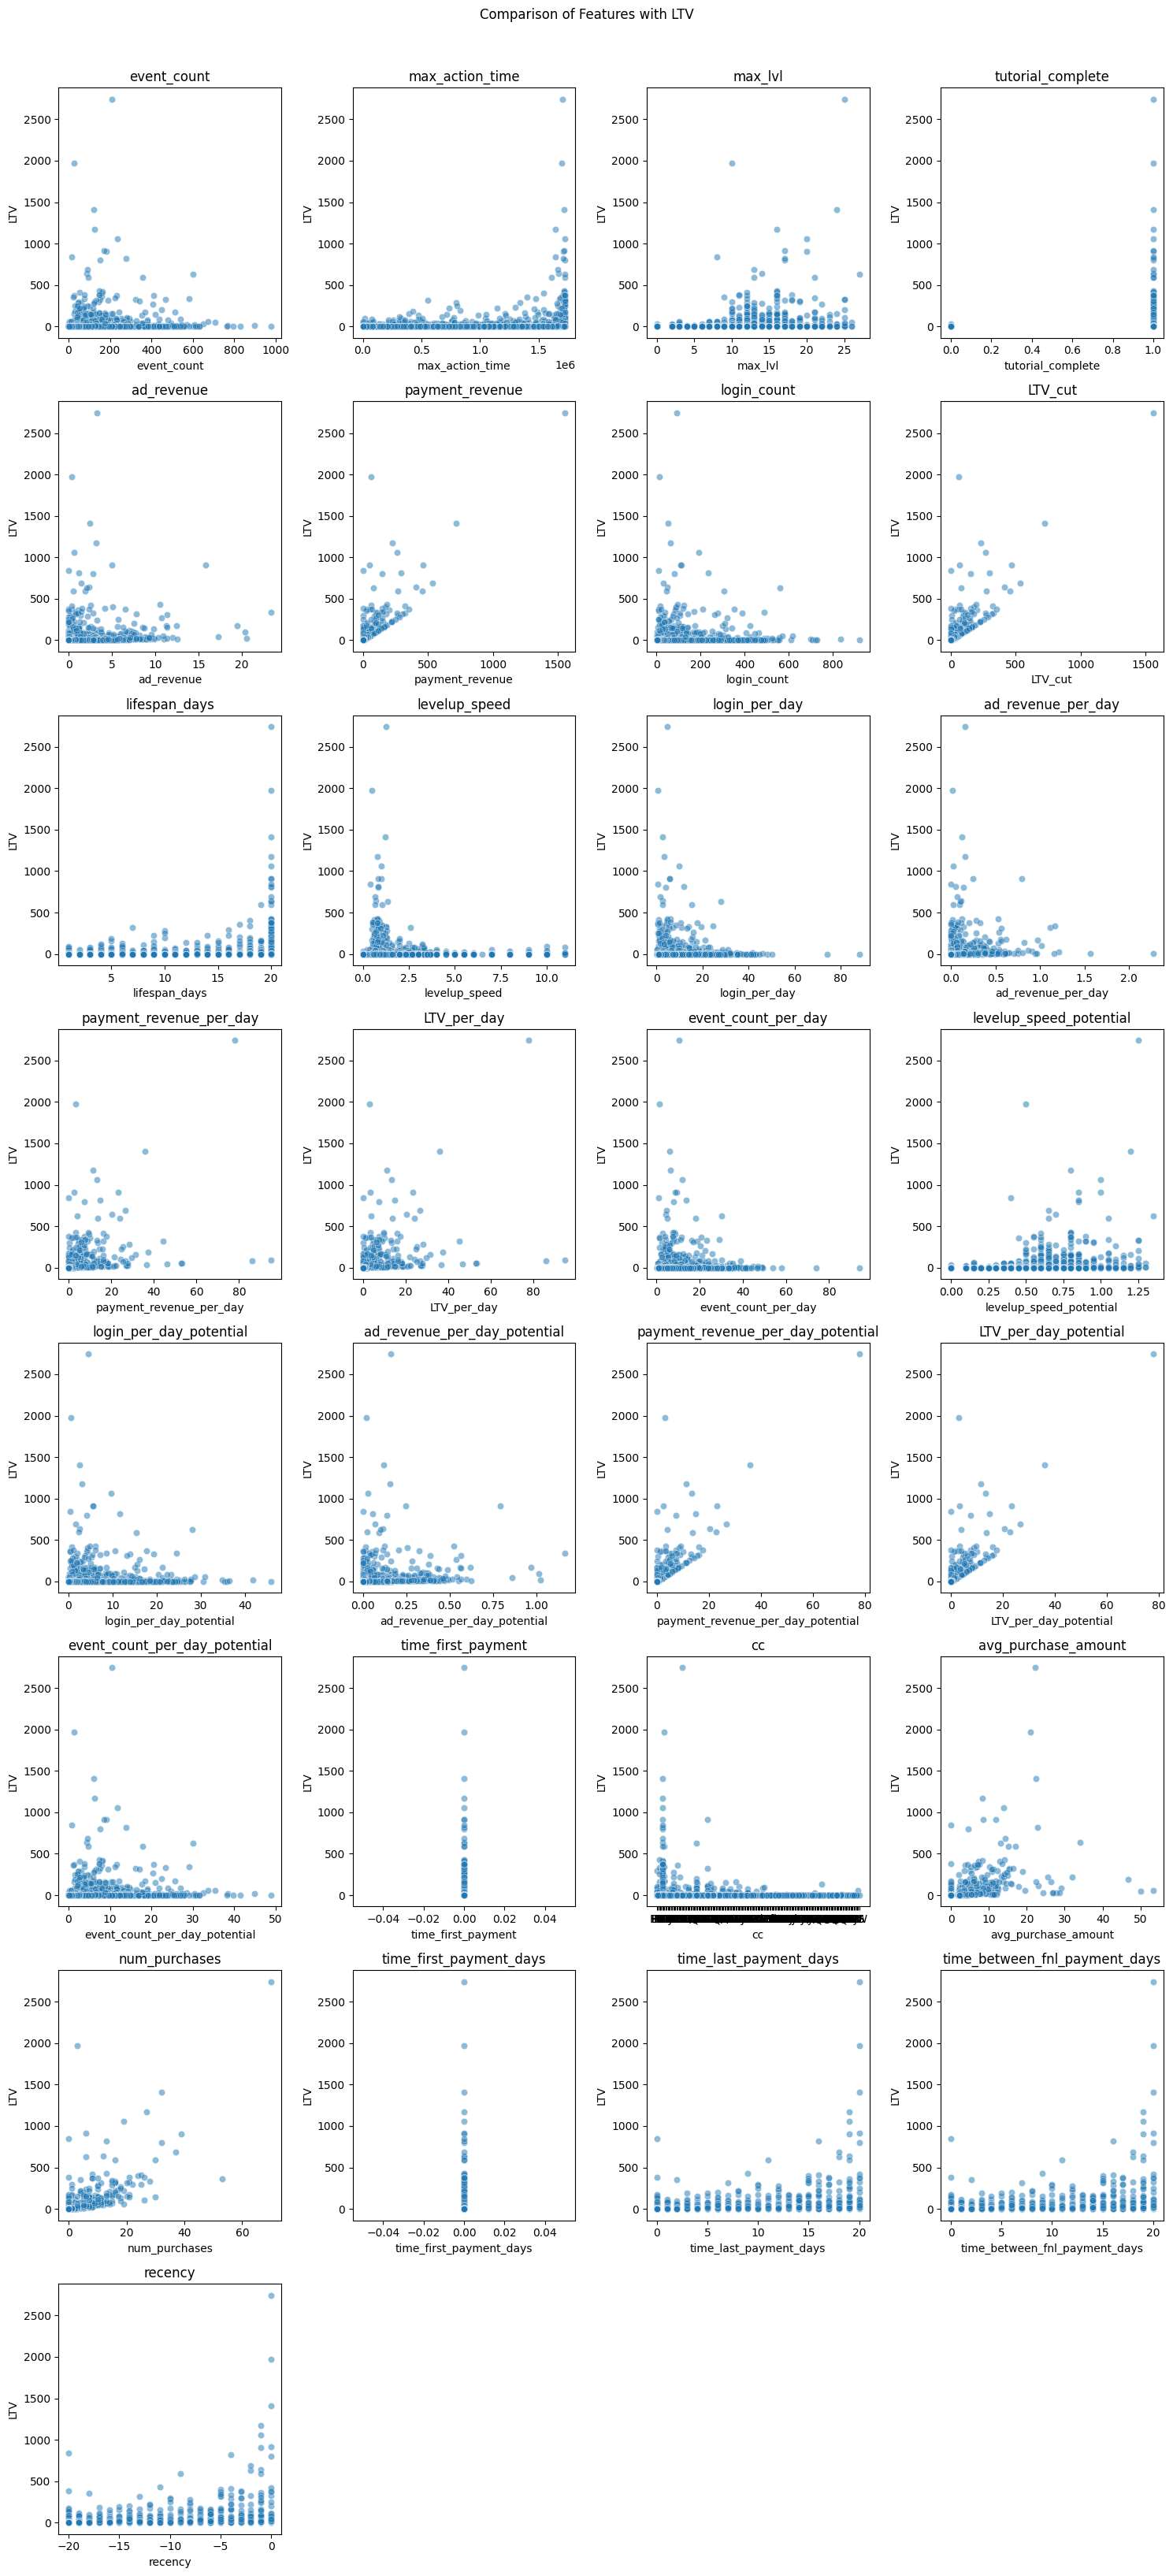

In [12]:
num_features = len(f_columns)

# количество строк и столбцов для графиков
num_cols = 4  # Количество столбцов
num_rows = (num_features + num_cols - 1) // num_cols  # Количество строк

# Создание парных графиков для каждой фичи относительно LTV
plt.figure(figsize=(15, num_rows * 4))
for i, column in enumerate(f_columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Создаем подграфик для каждой фичи
    sns.scatterplot(data=data_cut, x=column, y=y_col, alpha=0.5)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel(y_col)

plt.tight_layout()
plt.suptitle('Comparison of Features with LTV', y=1.02)  # Установка заголовка
plt.show()

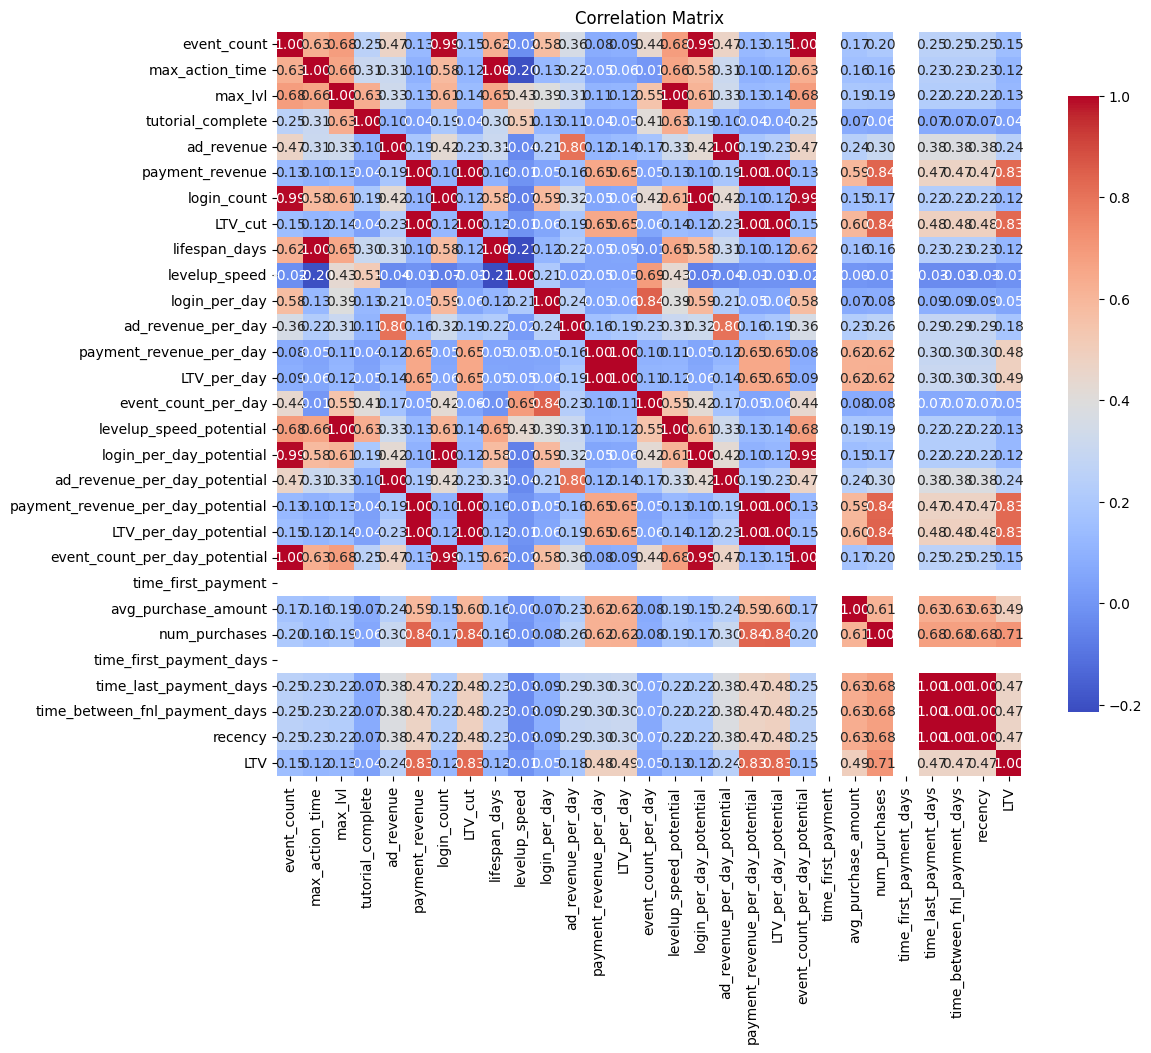

In [13]:
# вычисление корреляции
selected_columns = f_columns + [y_col]
correlation_matrix = data_cut[selected_columns].drop(columns=['cc']).corr()

# Создание тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

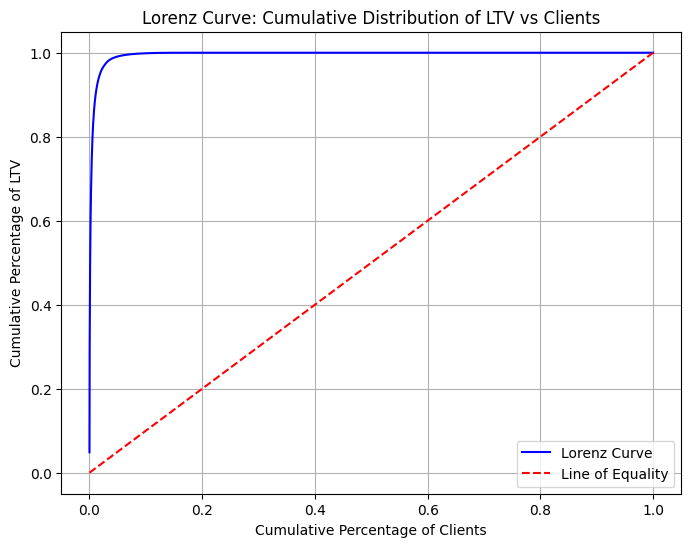

In [14]:
# Предположим, что у вас есть столбец 'LTV' с LTV для каждого клиента
df = data_true[['id', 'LTV']]  # Берем id клиентов и их LTV

# Сортируем клиентов по их LTV по возрастанию
df = df.sort_values(by='LTV', ascending=False)

# Вычисляем кумулятивный процент клиентов
df['cumulative_clients'] = np.arange(1, len(df) + 1) / len(df)

# Вычисляем кумулятивный процент LTV
df['cumulative_LTV'] = df['LTV'].cumsum() / df['LTV'].sum()

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(df['cumulative_clients'], df['cumulative_LTV'], label='Lorenz Curve', color='blue')

# Добавляем линию равенства для сравнения
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Line of Equality')

# Настройки графика
plt.title('Lorenz Curve: Cumulative Distribution of LTV vs Clients')
plt.xlabel('Cumulative Percentage of Clients')
plt.ylabel('Cumulative Percentage of LTV')
plt.legend()
plt.grid(True)
plt.show()

<Axes: xlabel='cumulative_clients'>

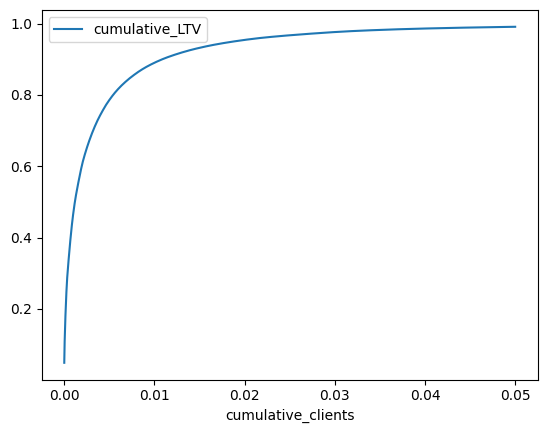

In [15]:
df.query('cumulative_clients<0.05').plot(x='cumulative_clients', y='cumulative_LTV')

In [16]:
df.query('cumulative_clients<0.005')

,id,LTV,cumulative_clients,cumulative_LTV
25338,8c46e2a0-6872-4dfe-b0f1-8db5d6c1cd93,2743.974231,0.000022,0.048668
40309,dfc6a267-7aca-490b-bd5c-90ee42877b4c,1972.215110,0.000043,0.083649
43245,f01a1157-8ede-4274-b0ca-81018be4d3d2,1408.963160,0.000065,0.108639
37382,cfc67a51-b6c6-430b-acb6-92ae73ed56b6,1173.958340,0.000087,0.129461
21279,7586c3da-16b7-44f1-b9ec-f2af8dfac5d1,1060.111530,0.000108,0.148263
...,...,...,...,...
37428,d0045293-1377-412e-ac44-39ed6f9f2528,44.970366,0.004898,0.781414
16077,58e89d8d-cecc-4ca6-a126-ca0c4a63449b,44.966348,0.004920,0.782211
8009,2c720177-4b6c-49fb-b2ee-49bf18083ae6,44.687116,0.004941,0.783004
14336,4f8be4f3-e558-40a6-910b-06ccd1daeef3,44.653813,0.004963,0.783796


## Пробую переформулировать задачу и прогнозировать не весь LTV за 120 дней, а лишь остаток (то есть за 100 дней)
Также переделал старитификацию по кумулятивной сумме LTV. Это снижает дисперсию.  
Еще пробую catboost

In [17]:
# Test the model on multiple random states
random_states = list(range(1))  # Define a list of random states
res = []
y_col = 'LTV_rest'

categorical_columns = ['cc']

for random_state in random_states:
    for threshold_days in [20]:  # You can add more thresholds if needed
        print(f'Testing threshold: {threshold_days} with random_state: {random_state}')
        data_cut = make_features_threshold(data_df, threshold_days)
        data_cut = data_cut.rename(columns={'LTV': 'LTV_cut'})
        data_cut = data_cut.merge(data_true[['id', 'LTV']], how='left', on='id')
        
        data_cut['LTV_rest'] = data_cut['LTV'] - data_cut['LTV_cut']
        
        X = data_cut[f_columns]
        y = data_cut[y_col]
        model = CatBoostRegressor(
            iterations=1000, 
            learning_rate=0.1,
            depth=6, 
            random_state=42, 
            verbose=0, 
#             early_stopping_rounds=50,
    )
        
        # Sort y by value to prepare for cumulative sum
        sorted_y = np.sort(y)

        # Compute the cumulative sum
        cumulative_y = np.cumsum(sorted_y)

        # Normalize the cumulative sum to get percentages
        cumulative_percentage = cumulative_y / cumulative_y[-1]

        # Define the bin edges at 20%, 40%, 60%, and 80% cumulative percentage
        bin_edges = np.interp([0.1, 0.2, 0.3, 0.4, 0.5], cumulative_percentage, sorted_y)

        # Use np.digitize to assign each value of y to one of the bins
        y_binned = np.digitize(y, bins=bin_edges)
        
        # Fit the model and store results
        res_dict = fit_model(
            X, 
            y, 
            model=model, 
            stratify=y_binned, 
            random_state=random_state, 
            categorical_columns=categorical_columns,
            log_transform=False,
        )
        res.append({**{'random_state': random_state, 'threshold_days': threshold_days}, **res_dict})


Testing threshold: 20 with random_state: 0
Training fold 1...
Fold 1 MSE: 181.3482 MAE: 0.7126 BIAS_ABS: 114 BIAS_REL: 1.02
Training fold 2...
Fold 2 MSE: 83.7343 MAE: 0.6367 BIAS_ABS: 2087 BIAS_REL: 1.60
Training fold 3...
Fold 3 MSE: 124.8738 MAE: 0.6613 BIAS_ABS: -533 BIAS_REL: 0.89
Training fold 4...
Fold 4 MSE: 419.8018 MAE: 0.8069 BIAS_ABS: -1118 BIAS_REL: 0.82
Training fold 5...
Fold 5 MSE: 246.6231 MAE: 0.7530 BIAS_ABS: -1615 BIAS_REL: 0.72

Mean MSE: 211.2762, Std MSE: 117.7797

Mean MAE: 0.7141, Std MAE: 0.0615


In [18]:
df_analyse = data_cut.merge(
    res[0]['predictions_df'],
    how='left',
    left_index=True, 
    right_index=True,
)
mse = mean_squared_error(df_analyse['LTV'], df_analyse['y_pred'] + df_analyse['LTV_cut'])
mae = mean_absolute_error(df_analyse['LTV'], df_analyse['y_pred'] + df_analyse['LTV_cut'])
print(f'MSE: {mse} MAE: {mae}')

MSE: 211.27624369507086 MAE: 0.7141189431887139


## Выводы
1. Лучше всех на данном этапе показывает себя линейная регрессия
2. В зависимости от того насколько часто нам нужно считать прогнозы можно сделать либо batch прогноз по клиентам, которые попадают под критерии для прогноза (с нами 20 дней) на ежедневной основе и загружать в БД. Либо можно сделать микросервис, который будет выдавать прогноз по клиенту, по которому пришел запрос. Все зависит от того как бизнес будет пользоваться данными. Можно сделать дашборд в BI системе для маркетинга по клиентам.
3. Можно пересчитывать модель хоть каждый день, но по-хорошему нужно провести исследование на предмет деградации точности модели, оценив бэк-тестом путем time-series cross-validation. 
4. Также важно настроить мониторинги на перформанс модели и на предмет дрифта данных.
5. Возможно, будет иметь смысл построить модель для нулевого дня. Если у нас есть достаточно признаков о клиенте, то мы можем попытаться сразу предсказать его LTV.

## Что еще хотелось бы попробовать:
* Поокруглять метрики, бинаризовать, заюзать бустинги еще раз
* поделить сет по таргету на бины, соответствующие накопительному LTV
* попробовать эконометрический подход с библиотекой lifetimes
* пойти в DL
* прогнозировать отдельно отток, отдельно покупки
* отдельно прогнозировать нулевых клиентов и самых дорогих
* under/over sampling